# Yet another introduction to Neural Networks

In this notebook, I will explain how to implement a neural network from scratch and use the version of MNIST dataset that is provided within Scikit-Learn for testing. I will specificallty illustrate the use of Python classes to define layers in the network as objects. Each layer object has forward and backward propagation methods which leads to compact, easily readable code. In writing this tutorial, I've had inspiration from [Peter Roelants'](http://peterroelants.github.io/) page. 

In [1]:
## Imports

import numpy as np
from sklearn.datasets import load_digits

### Data preparation

After loading the data, we divide it into three parts, training, validation and testing sets. The validation set is to be used to determine the hyperparameters (i.e. number and size of hidden layers and regularization parameter) and the testing set is a separate picece of data to assess the final model performance. 

In [2]:
## Load the data and reshape images
digits = load_digits()
n_samples = len(digits['images'])
data = digits['images'].reshape((n_samples, -1)); targets = digits['target']

## Train-test splitting
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(data, targets, test_size=0.33, random_state=111)

## Train and validation splitting
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=123)

### Activation function and classifier

We will use the sigmoid activation function $\sigma(x) = 1/(1+e^{-x})$ in the layers of the network. For the classifier, we will use the softmax functio, which results in class probabilities:

$$ {\rm softmax}_i({\bf Y}) = \frac{e^{Y_i}}{\sum_{k=1}^K\, e^{Y_k}} $$

where $Y_i$ is vector from the output of the neural network for a given example, and $K$ is the number of classes (10 in our case). Both functions are implemented below:

In [3]:
## Define the activation function, the Softmax classifier 
# Sigmoid function
def sigmoid(X):
    return 1.0 / (1.0 + np.exp(-X))

# Softmax function
def softmax(X):
    temp = np.max(X, axis = 0) # Determine the maximum of each column
    X = X - temp               # Subtract the max from each: does not change outcome
    return np.exp(X) / np.sum(np.exp(X), axis = 0) 

In the above implementations, the assumption is that the arguments of both functions are cast in a matrix columnwise, so that each column represents one example: $ {\bf X} \in {\mathbb R}^{n_{\rm feat} \times N}$ where $N$ is the number of examples and $n_{\rm feat}$ is the number of features (i.e. number of pixels in our case). In softmax, we have subtracted the maximum of each column from each training example vector, an operation that does not change the outcome, for numerical stability.

Now that we have our data, the activation function and the classifier, we can construct the layers of the network. 

### Linear Update

First, we define the class LinearUpdate which performs the linear transformation of the (derived) features in the current layer:

$${\bf Y}^{(i)} = {\bf W}^{T} \cdot A^{(i)} + {\bf b}$$ 

In this equation, ${\bf A}^{(i)} \in {\mathbb R}^{n_{\rm in}} $ represents the **current layer state** (i.e features in case of input layer and derived features in case of hidden layers) with $n_{\rm in}$ being the number of neurons. $Y^{(i)} \in {\mathbb R}^{n_{\in out}}$ is the linear ouput of the current layer (which will later be the argument of an activation function) which is passed  as the **input** to the next layer with $n_{\rm out}$ neurons. The supersript (i) refers to the training example being considered. Instead of using a *for loop* over the training examples, we can cast them in a matrix where each column is one training example vector $Y^{(i)}$, i.e.

$$Y^{(i)}_j \rightarrow Y_{ji} : {\bf Y} \in {\mathbb R}^{n_{\rm out} \times N}$$

where $N$ is the number of training examples. Similary $A^{(i)}_j \rightarrow A_{ji} : {\bf A} \in {\mathbb R}^{n_{\rm in} \times N}$.

#### Forward propagation

The above equation can be simply written in matrix notation as ${\mathbf Y} = {\mathbf W}^T \cdot {\bf A} + {\bf b}$. The weights ${\bf W} \in {\mathbb R}^{n_{\rm in} \times n_{\rm out}}$ and biases ${\bf b} \in {\mathbb R}^{n_{\rm in}}$ will be determined during training by the minimization of a loss function $L$. 

The LinearUpdate object is initialized with $n_{\rm in}$, $n_{\rm out}$, the weights and biases. The forward method below implements the above equation. 

#### Back propagation

The backpropagation method simply takes the gradient of the loss function with respect to the **state of the next layer** ($\nabla_{\bf Y} L$) and computes the gradients with respect to the **current state** ($\nabla_{\bf A}L$), **weights** ($\nabla_{\bf W}L$) and **biases** ($\nabla_{\bf b}L$). The backpropagation rules can be derived by noting that:

$$ Y_{ji} = \sum_{k=1}^{n_{\rm in}}\, \left( W^T \right)_{jk}\, A_{ki} + b_j $$

First, the gradient of the loss function $L$ with respect to the weights ${\bf W}$ can be written as:

$$ \frac{\partial L}{\partial W_{ln}} = \sum_{i=1}^N\, \sum_{j=1}^{n_{\rm out}}\, \frac{\partial L}{\partial Y_{ji}}\, \frac{\partial Y_{ji}}{\partial W_{ln}} = \sum_{i=1}^N\, \frac{\partial L}{\partial Y_{ni}}\, A_{li}$$

We denote the gradient from the next layer $\frac{\partial L}{\partial Y_{ji}}$ as $\nabla_{\bf Y} L$, and the above equation in matrix form becomes

$$ \nabla_{\bf W} L = {\bf A} \cdot (\nabla_{\bf Y} L)^T$$

Similarly, we can compute gradients with respect to ${\bf A}$ and ${\bf b}$, and following similar steps, we obtain

$$ ( \nabla_{\bf b} L )_l = \sum_{i=1}^N\, (\nabla_{\bf Y} L)_{li} $$
$$ \nabla_{\bf A} L = {\bf W} \cdot (\nabla_{\bf Y} L) $$

All of these three backpropagation rules are implemented below in the backward method of LinearUpdate.

In [4]:
## Define Linear Update
class LinearUpdate(object):
    def __init__ (self, n_in, n_out, W = None, b = None):
        # Initialize W randomly
        eps = np.sqrt(6.0) / np.sqrt(n_in + n_out)
        self.W = (np.random.uniform(-eps, eps, (n_in, n_out)) if W is None else W)
        
        # Initialize biases as zero
        self.b = np.zeros((n_out,1))
        
    def forward(self, A):
        """ Forward propagation method: A is current state, method results in next state linearly
            Y <- W.T * A + b
        """
        return np.dot(self.W.T, A) + self.b
    
    def backward(self, A, gY):
        """ Backward propagation method: A is current state, gY is backpropagated derivative from 
            next layer.
        """
        gW = np.dot(A, gY.T)       # dL/dW_ab = sum_i A_ai * (gY)_bi
        gA = np.dot(self.W, gY)    # dL/dA_ab = sum_j ( (W)_aj * gY_jb )  
        gb = np.sum(gY, axis=1)    # dL/db_l = sum_i (gY)_li
        
        return gA, gW, gb

### Logistic Update

Now we implement the object which takes the outcome of the linear update, and transforms it with the actiovation function. Our choice for the activation is the sigmoid function defined above. The activation function takes the **input into the layer** (let's denote by $Z$) and generates an output $\sigma(Z)$ which will be passed to the next layer. Specifically, we will have:

$$ {\bf Z} = {\bf W}^T \cdot {\bf A} + {\bf b}$$
$$ {\bf Y} = \sigma({\bf Z})$$

i.e., the linear output ${\bf Z}$ will be transformed by the activation function and then passed to the next layer. 

The forward and backward propagation methods are easily obtained as follows:

$$ {\bf Y} = \sigma(Z), \quad
\frac{\partial L}{\partial {\bf Z}} = \frac{\partial L}{\partial {\bf Y}} \cdot \frac{\partial {\bf Y}}{\partial {\bf Z}} = {\bf Y} \odot (1-{\bf Y}) \odot (\nabla_{\bf Y}L)$$

where ${\bf Y}$ is the **input into the next layer** and $\nabla_{\bf Y}L$ is the gradient with respect to the **input of the next layer** and $\odot$ denote elementwise multiplication.

In [5]:
## Define Logistic Update
class LogisticUpdate(object):
    def forward(self, Z):
        """ Sigmoid activation: """
        return sigmoid(Z) #  Y = sigmoid(Z)
    
    def backward(self, Y, grad_out):
        """ Backward propagation: """
        return np.multiply(Y * (1 - Y), grad_out)   # dL/dZ = dL/dY * Y * (1-Y)

### Classifier

The output layer will be the classifier which deserves its own class. The forward method is still the sigmoid function, which will output class probabilities. The backward method implements the gradient of the loss function with respect to the outputs of the network. Finally, the crossEntropy method defines the loss function:

$$ L = -\frac{1}{N}\, \sum_{i=1}^{N}\, \sum_{k=1}^K\, \log(P_{ki})\, I(T_i = k) $$

where $P_{ki}$ is the calculated probability of training example $(i)$ being of class $k$, and the function $I$ is $1$ when the target (i.e. the actual value of the digit) is of class $k$, and zero otherwise. Evaluating the derivative of the loss function with respect to the **ouput layer state** ${\bf Y}$ results in

$$ \frac{\partial L}{\partial {\bf Y}}  = \frac{1}{N}\, ({\bf P} - {\bf I}) $$

These methods are implemented below.

In [6]:
# Define Softmax Classifier layer
class SoftmaxClassifier(object):
    def forward (self, A): 
        """ Given state A, produces output probs P by softmax """
        return softmax(A)
    
    def backward(self, P, T):
        """ Given output probs P and targets T, produces output gradient """
        expansionMatrix = np.eye(P.shape[0], dtype = int)
        expandedTarget = expansionMatrix[:, T]
        
        return P - expandedTarget # No division by number of samples yet.
    
    def crossEntropy(self, P, T):
        """ Computes cross entropy """
        expansionMatrix = np.eye(P.shape[0], dtype = int)
        expandedTarget = expansionMatrix[:, T]
        
        CE = -np.sum(expandedTarget * np.log(P + 1e-30))/P.shape[1]
        return CE

### Neurons

Now that we have defined how states in a layer is forward propagated (first linearly, then by the activation function), we can use the LinearUpdate and LogisticUpdate classes to define the Layer class. The layer class first linearly transforms the current state vectors ${\bf A}$ and then feeds them into the activation layer to yield the **input to the next layer** ${\bf Y}$ by the forward method. In the backward method, the incoming gradient is first backpropagated through the logistic update, then by the linear update to yield the gradients with respect to **curent layer states**, weights and biases.

Just for a sanity check, we can explicitly evaluate the backpropagation for ${\bf A}$ as an example as follows:

$$ {\bf Y} = \sigma({\bf Z}), \quad {\bf Z} = {\bf W}^T \cdot {\bf A} + {\bf b}$$


$$ \frac{\partial L}{\partial A_{ln}} = \sum_{i=1}^N\, \sum_{j=1}^{n_{\rm out}}\, \frac{\partial L}{\partial Y_{ji}}\, \frac{\partial Y_{ji}}{\partial Z_{ji}}\, \frac{\partial Z_{ji}}{\partial A_{ln}} = \sum_{j=1}^{n_{\rm out}}\, (\nabla_{\bf Y} L)_{jn}\, Y_{jn}\, (1-Y_{jn})\, W_{lj}$$

$$ (\nabla_{\bf A} L) =  {\bf W} \cdot \left[{\bf Y} \odot (1-{\bf Y}) \odot (\nabla_{\bf Y}L) \right]$$

which are is implemented in two steps; first ${\bf Y} \odot (1-{\bf Y}) \odot (\nabla_{\bf Y}L)$ as the backward method of the LogisticUpdate which is fed into the backward method of LinearUpdate to yield its dot product with ${\bf W}$.

In [7]:
## Define Layes (combine linear and logistic updates)
class Layer(object):
    def __init__ (self, n_in, n_out):
        self.linear = LinearUpdate(n_in, n_out)
        self.logistic = LogisticUpdate()
        
    def forward(self, A):
        """ Forward propagation method """
        return self.logistic.forward(self.linear.forward(A))
    
    def backward(self, A, Y, grad_out):
        """ Backward propagation method """
        # First the derivative of the logistic State
        gZ = self.logistic.backward(Y, grad_out)
        # Then, gZ becomes gY for the linear state
        gA, gW, gb = self.linear.backward(A, gZ) 
        
        return gA, gW, gb 

## Construct the network

Now we have the Layers and the Classifier objects, we can construct the neural network. We also add a regularization term to the loss function, which will be determined by the validation set performance below.
The regularization term is given by

$$ L_{\rm reg} = \frac{\lambda}{2 N}\, \sum_{l=1}^{N_{\rm layers}}\, \vert {\bf W}_l \vert^2 $$

which is a sum over all the layers and penalizes the weights in all the layers using their square norm defined as

$$ \vert {\bf W}_l \vert^2 = \sum_{i,j}\, (W_l)_{ij}^2 $$

In [8]:
## Construct a two hidden layer network
class nnet(object):
    def __init__ (self, nInput, nHidden1, nHidden2, K):
        """ Initiate method for the net """
        self.inputLayer = Layer(nInput, nHidden1)     # Input layer
        self.hiddenLayer1 = Layer(nHidden1, nHidden2) # 1st hidden layers
        self.hiddenLayer2 = Layer(nHidden2, K)        # 2nd hidden layer
        self.classifier = SoftmaxClassifier()         # Output: classification
    
    def forward(self, input_train):
        """ Perform forward propagation through all layers """
        A1 = input_train.T                 # Initial data
        A2 = self.inputLayer.forward(A1)   # inp -> hid1 
        A3 = self.hiddenLayer1.forward(A2) # hid1 -> hid2
        A4 = self.hiddenLayer2.forward(A3) # hid2 -> out
        P = self.classifier.forward(A4)    # output probabilities
        
        return A1, A2, A3, A4, P
    
    def backward(self, P, A4, A3, A2, A1, T, lam = 0.0):
        """ Back propagation method through all layers """
        grad_out = self.classifier.backward(P, T)                    # output grads
        gA3, gW3, gb3 = self.hiddenLayer2.backward(A3, A4, grad_out) # hid2 grads
        gA2, gW2, gb2 = self.hiddenLayer1.backward(A2, A3, gA3)      # hid1 grads
        gA1, gW1, gb1 = self.inputLayer.backward(A1, A2, gA2)        # input grads
        
        # Add regularization terms to the gradients
        if (lam > 0.0):
            gW3 += lam * self.hiddenLayer2.linear.W
            gW2 += lam * self.hiddenLayer1.linear.W
            gW1 += lam * self.inputLayer.linear.W
        
        return grad_out, gW3, gb3, gW2, gb2, gW1, gb1
    
    def Loss(self, P, T, lam = 0.0):
        """ Method for computing loss """        
        # Regularization term
        reg = np.sum(self.inputLayer.linear.W**2) + np.sum(self.hiddenLayer1.linear.W**2) + \
              np.sum(self.hiddenLayer2.linear.W**2)
        
        # Full loss
        return self.classifier.crossEntropy(P, T) + (0.5*lam/P.shape[1]) * reg

Below is a function that will be used to train the network. We use the momentum method to update the gradients of weights as follows:

$$ {\bf V} \leftarrow \mu\, {\bf V} - \alpha\, \nabla_{\bf W}\, L $$
$$ {\bf W} \leftarrow {\bf W} + {\bf V} $$

where $\mu$ is the momentum and $\alpha$ is the learning rate. A similar update method also holds for the biases. All velocities are initialized as zeros in the beginning. You can read more about the mometum method [here](http://sebastianruder.com/optimizing-gradient-descent/index.html#momentum). 

This function returns the trained network, calculated training and validation losses, and the validation accuracy. As a side note, we are using all the training data to compute the gradients. This is because the training set is small enough. In real situtations, one would be advised to batches. You can read more about these [here](http://sebastianruder.com/optimizing-gradient-descent/index.html#batchgradientdescent).

In [9]:
def trainNetwork(epochs, learningRate, momentum, lam, n_hidden_1, n_hidden_2, K):
    """ Function for training the network """
    
    ## Construct network
    network = nnet(n_input, n_hidden_1, n_hidden_2, K)
    
    ## Initiate velocities
    v_W1 = np.zeros_like(network.inputLayer.linear.W) 
    v_W2 = np.zeros_like(network.hiddenLayer1.linear.W)
    v_W3 = np.zeros_like(network.hiddenLayer2.linear.W)
    v_b1 = np.zeros_like(network.inputLayer.linear.b) 
    v_b2 = np.zeros_like(network.hiddenLayer1.linear.b)
    v_b3 = np.zeros_like(network.hiddenLayer2.linear.b)
    
    ## Train
    losses = {'train':[], 'validation':[]}
    for epoch in range(epochs):
        # Feed forward 
        A1, A2, A3, A4, P = network.forward(X_train)
        
        # Backprop
        grad_out, gW3, gb3, gW2, gb2, gW1, gb1 = network.backward(P, A4, A3, A2, A1, y_train, lam)
    
        # Update weights by momentum method (Divide by the number of examples in the batch)
        v_W1 = momentum * v_W1 - learningRate * gW1/n_train
        v_W2 = momentum * v_W2 - learningRate * gW2/n_train
        v_W3 = momentum * v_W3 - learningRate * gW3/n_train
    
        network.hiddenLayer2.linear.W += v_W3
        network.hiddenLayer1.linear.W += v_W2
        network.inputLayer.linear.W += v_W1
    
        # Update biases by momentum method (Divide by the number of examples in the batch)
        v_b1 = momentum * v_b1 - learningRate * gb1[:,None]/n_train
        v_b2 = momentum * v_b2 - learningRate * gb2[:,None]/n_train
        v_b3 = momentum * v_b3 - learningRate * gb3[:,None]/n_train
    
        network.hiddenLayer2.linear.b += v_b3
        network.hiddenLayer1.linear.b += v_b2
        network.inputLayer.linear.b += v_b1
    
        # Compute loss on training set
        loss_train = network.Loss(P, y_train, lam)
        losses['train'].append(loss_train)
    
        # Compute loss on validation set
        A1, A2, A3, A4, P = network.forward(X_valid)
        loss_valid = network.Loss(P, y_valid, lam)
        losses['validation'].append(loss_valid)
        
        # Compute validation accuracy
        pred = np.argmax(P, axis = 0)
        
        # Accuracy
        acc = np.sum((pred == y_valid).astype(float))/y_valid.shape[0]

    # Return the trained network and the losses
    return network, losses, acc

### Determining the hyperparameters

Now we will train the network for a range of values for hyperparameters and determine the best ones based on their performance on the validation set. For illustration, we only choose to optimize the regularization parameter $\lambda$ and keep all others constant. 

In [10]:
## Setup: For this example, just vary the regularization parameter
epochs=1000
learningRate = 0.2
momentum = 0.9

# Network structure
n_hidden_1 = 48
n_hidden_2 = 32
K = 10
n_input = X_train.shape[1]
n_train = X_train.shape[0]

# Values of lambda to try
lambda_l2 = np.logspace(-2,2,10)

# Train
dict_acc = {'lambda':[], 'acc':[]}; count=1
for lam in lambda_l2:
    network, _, acc = trainNetwork(epochs, learningRate, momentum, lam, n_hidden_1, n_hidden_2, K)
    dict_acc['lambda'].append(lam)
    dict_acc['acc'].append(acc)
    print "Trained %d of %d networks" % (count, lambda_l2.shape[0])
    count +=1

Trained 1 of 10 networks
Trained 2 of 10 networks
Trained 3 of 10 networks
Trained 4 of 10 networks
Trained 5 of 10 networks
Trained 6 of 10 networks
Trained 7 of 10 networks
Trained 8 of 10 networks
Trained 9 of 10 networks
Trained 10 of 10 networks


Let's plot the accuracy as a function of the regularization parameter:

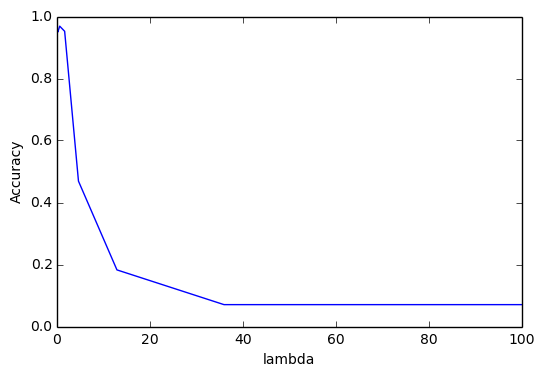

In [11]:
## Plot the training and validation losses
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(dict_acc['lambda'],dict_acc['acc'])
plt.xlabel('lambda')
plt.ylabel('Accuracy')

### Final Network

Now that we have determined the value of $\lambda$ using the validation set, we can train the network one last time and predict on the test set. This will give us the prediction accuracy of our network. 

In [12]:
# Best lambda
lam_best = lambda_l2[np.argmax(dict_acc['acc'])]
best_validation_acc = max(dict_acc['acc'])

# One final training with the best model
network, losses, acc = trainNetwork(epochs, learningRate, momentum, lam_best, n_hidden_1, n_hidden_2, K)

## Predict on the test set
A1, A2, A3, A4, P = network.forward(X_test)

# Predict digits
pred_test = np.argmax(P, axis = 0)
        
# Accuracy
acc_test = np.sum((pred_test == y_test).astype(float))/y_test.shape[0]

print "Best lambda: %.6f, Validation set accuracy: %.6f" % (lam_best, acc)
print "Test set accuracy: %.6f" % acc_test

Best lambda: 0.599484, Validation set accuracy: 0.964730
Test set accuracy: 0.959596


Pretty good!

Finally, let's plot the training and validation loss values during the training. Since we are using the full batch to train the model (i.e. all the training set), we do not observe any oscillations and a smooth decrease of the loss function.

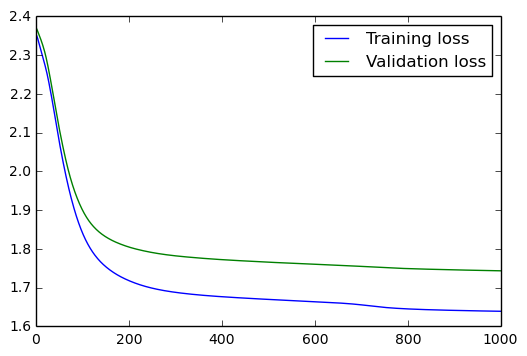

In [13]:
## Plot the training and validation losses
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()